In [0]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
!pip install pycountry

In [0]:
import pycountry

# Data Preprocessing & Feature Engineering
## Import Dataset:

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/Pitch2342/Rand/master/UFC_Dataset/data.csv") # original dataset
print(f"Initial shape: {df.shape}")
df.head()


Initial shape: (5144, 145)


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_opp_KD,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_opp_PASS,B_avg_opp_REV,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_opp_SIG_STR_pct,B_avg_opp_SUB_ATT,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_opp_TD_pct,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_total_rounds_fought,B_total_time_fought(seconds),B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_BODY_att,R_avg_BODY_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_KD,R_avg_LEG_att,R_avg_LEG_landed,R_avg_PASS,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,1.000000,0.60000,51.200000,17.400000,0.600000,0.200000,39.600000,9.400000,0.200000,6.80000,4.800000,0.000000,0.000000,52.800000,18.20000,0.236000,0.000000,1.000000,0.400000,0.100000,53.800000,19.200000,9.0,419.400000,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,Orthodox,167.64,170.18,135.0,0.0,4.0,0.0,21.900000,16.400000,17.000000,11.000000,75.000000,26.500000,9.400000,6.500000,74.200000,23.90,0.400,5.300000,3.700000,1.200000,0.000000,101.400000,44.000000,0.466000,0.100000,5.300000,1.900000,0.458000,129.900000,69.100000,4.0,2.0,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,

## Exclude Match Level Data
To predict the matches before they take place, columns consisting of match level data are to be dropped (e.g: Location, Data, ...):

In [5]:
keep = np.array([6,10,11,12,37,38,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,104,105,130,132,133,134,135,136,137,138,139,140,141,142,143,144,145]) - 1
df = df.iloc[:,keep] # exclude match level data

df = df.replace(r'^\s*$', np.nan, regex=True) # replace empty string with nan

df = df.round(3) # format data

df.rename(columns={ # some renaming
    "B_win_by_KO/TKO": "B_win_by_KO_TKO",
    "R_win_by_KO/TKO": "R_win_by_KO_TKO"},inplace=True)
print(f"shape: {df.shape}")

shape: (5144, 39)


## Remove 'Draw' matches:
1.  'Draw Rate is low'
2. The problem is assumed to be a **binary classification** (win/loss only)

In [6]:
# considering matches with a winner as this will be a binary classification
drawRate = round(len(df["Winner"][df["Winner"]== "Draw"])/len(df.index)*100,3)
print(f"Draw rate is: {drawRate}%, converting to nan")
df["Winner"] = df["Winner"].replace("Draw", np.nan) # convert to nan to be dropped later

Draw rate is: 1.614%, converting to nan


## Remove Constant Columns:
Constant columns have no variation therefore won't affect models.

In [7]:
def remove_constant_cols(df):
    categorical = list(df.select_dtypes(include=['object']))
    numeric = df.columns.tolist()
    for c in categorical:
        numeric.remove(c)
    
    constants = []
    for col in numeric:
        if min(df[col]) == max(df[col]):
            constants.append(col)
    if len(constants)>0: 
        print(f"removing constants: {constants}")
        return df.drop(columns = constants, axis=1, inplace=True)
    else:print("no constant found")
        
remove_constant_cols(df) # removes columns without variation

# distinguish categorical and numeric
categorical = list(df.select_dtypes(include=['object']))
numeric = df.columns.tolist()
for c in categorical:
    numeric.remove(c)   
print(f"\n# Categoricals {len(categorical)}")
print(f"# Numerics {len(numeric)}")

removing constants: ['B_draw', 'R_draw']

# Categoricals 3
# Numerics 34


## 1-Hot-Encoding
Remove null in Stance prior to 1-hot-encoding.

In [8]:
# drop na rows in 'Stance' prior to 1-hot-encoding
print(f"% nan in R/B Stance: {round(df['R_Stance'].isnull().sum()/df.shape[0]*100,2)}, {round(df['B_Stance'].isnull().sum()/df.shape[0],2)}. Dropped!")
df.dropna(subset=["R_Stance", "B_Stance"], inplace=True, axis=0) #drop nan in Stance columns

# 1-hot-encode 'Stance'
toBeEncoded = [14,31]
ufc_encoded = df.iloc[:,toBeEncoded]
ufc_encoded = pd.get_dummies(ufc_encoded)
ufc_encoded.rename(columns={
    "B_Stance_Open Stance": "B_Stance_Open_Stance",
    "R_Stance_Open Stance": "R_Stance_Open_Stance"},inplace=True)
df.drop(df.columns[toBeEncoded], axis=1, inplace=True) # drop initial uncoded fields
df = pd.concat([df,ufc_encoded],1) # concat 
df.head()

% nan in R/B Stance: 2.6, 0.03. Dropped!


,Winner,B_current_lose_streak,B_current_win_streak,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO_TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO_TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,B_Stance_Open_Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open_Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,0.0,4.0,4.0,1.0,9.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,167.64,170.18,135.0,0.0,4.0,4.0,2.0,27.0,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,162.56,162.56,135.0,31.0,32.0,0,1,0,0,0,0,1,0,0,0
1,Red,0.0,3.0,3.0,6.0,29.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,4.0,167.64,167.64,125.0,0.0,2.0,2.0,2.0,25.0,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,165.10,167.64,125.0,32.0,31.0,0,1,0,0,0,0,0,0,1,0
2,Red,0.0,3.0,8.0,8.0,68.0,1.0,0.0,0.0,7.0,10.0,6.0,0.0,23.0,185.42,185.42,155.0,0.0,11.0,11.0,1.0,33.0,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,180.34,193.04,155.0,36.0,35.0,0,1,0,0,0,0,1,0,0,0
3,Blue,0.0,4.0,4.0,0.0,9.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,170.18,170.18,135.0,1.0,0.0,5.0,2.0,20.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,6.0,162.56,172.72,135.0,26.0,29.0,0,0,0,0,1,0,1,0,0,0
4,Blue,0.0,1.0,1.0,1.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,180.34,185.42,250.0,1.0,0.0,3.0,1.0,7.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,187.96,190.50,264.0,32.0,26.0,0,0,0,1,0,0,0,0,1,0


## Missing Values Treatment:

In [9]:
# get percent missing in columns
missing = round(df.isnull().sum()/df.shape[0]*100,2)
print(f'\n% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')


% Missing in 7 Features:
Winner           1.58
B_Height_cms     0.04
B_Reach_cms     12.86
B_Weight_lbs     0.04
R_Reach_cms      5.90
B_age            3.15
R_age            0.98
dtype: float64


As B_Reach_cms has largest percentage of missing values, it has to be handled.
Moreover, Reach is a physical measurement of a fighter; it is good idea to analyse similar physical features. For this, we have to combine Reach, Height and Weight of both fighters

In [10]:
# fighters physical measures
fighter_measures = df.iloc[:,np.array([14,15,16,30,31,32])] 

# merge values from both fighters
fighter_height = list(pd.concat([fighter_measures["B_Height_cms"],fighter_measures["R_Height_cms"]],0)) 
fighter_reach = list(pd.concat([fighter_measures["B_Reach_cms"],fighter_measures["R_Reach_cms"]],0)) 
fighter_weight = list(pd.concat([fighter_measures["B_Weight_lbs"],fighter_measures["R_Weight_lbs"]],0)) 

# create dataframe
fighter_measures=pd.DataFrame(data={'height':fighter_height,'reach':fighter_reach,'weight':fighter_weight})
fighter_measures.dropna(inplace=True) #don't need nan here
print(fighter_measures.head())


   height   reach  weight
0  167.64  170.18   135.0
1  167.64  167.64   125.0
2  185.42  185.42   155.0
3  170.18  170.18   135.0
4  180.34  185.42   250.0


###  1- Replace nan of Height with its median
Only ~0.12% of Heights is missing; replace NAs with median of its column.

In [11]:
# Missing Value Treatment:
# 1- replace nan of Height with its median
df["B_Height_cms"] = df["B_Height_cms"].fillna(value=df["B_Height_cms"].median())
df["R_Height_cms"] = df["R_Height_cms"].fillna(value=df["R_Height_cms"].median())

# get percent missing in columns
missing = round(df.isnull().sum()/df.shape[0]*100,2)
print(f'\n% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')


% Missing in 6 Features:
Winner           1.58
B_Reach_cms     12.86
B_Weight_lbs     0.04
R_Reach_cms      5.90
B_age            3.15
R_age            0.98
dtype: float64


Reach has largest percentage of missings. Let's perform some analysis on it:

In [12]:
# boxplots
fig = go.Figure()
fig.add_trace(go.Box(y=fighter_measures["height"], name='height',
                marker_color = 'indianred'))
fig.add_trace(go.Box(y=fighter_measures["reach"], name = 'reach',
                marker_color = 'lightseagreen'))
fig.update_layout(
    title="Height & Reach BoxPlots",
    xaxis_title="Body Measures",
    yaxis_title="Cms",
)



As shown above, Reach and Height have a similar range. <br> Let's plot a correlation heatmap to better understand the relations:

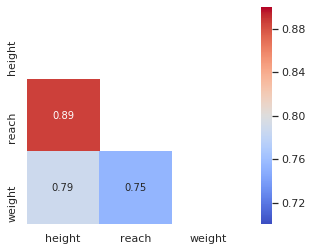

In [13]:
# correlation heatmap
corr = fighter_measures.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(corr, mask=mask, vmin=0.7,vmax=0.9,center=0.8, square=True, annot=True,cmap="coolwarm")

As shown in the heatmap, there is 89% correlation between height and reach. Therefore, a Linear Regression Model may be used to predict missing values in reach, based on the height.

### 2- Predict reach based on height via Linear Regression

In [14]:
# Missing Value Treatment:
# 2- predict reach based on height via Linear Regression

X = fighter_measures['height'].values.reshape(-1,1)
y = fighter_measures['reach'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

# predict function
def predict_with_lr(arr):
    return regressor.predict(np.array(arr.tolist()).reshape(-1,1))

# replace nan in 'reach' using LR
df["R_Reach_cms"][pd.isna(df["R_Reach_cms"])] = predict_with_lr(df[pd.isna(df["R_Reach_cms"])]["R_Height_cms"])
df["B_Reach_cms"][pd.isna(df["B_Reach_cms"])] = predict_with_lr(df[pd.isna(df["B_Reach_cms"])]["B_Height_cms"])

# get percent missing in columns
missing = round(df.isnull().sum()/df.shape[0]*100,2)
print(f'% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')

% Missing in 4 Features:
Winner          1.58
B_Weight_lbs    0.04
B_age           3.15
R_age           0.98
dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 3- Drop remaining nan

In [15]:
# Missing Value Treatment:
# 3- drop remaining nan
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True, drop=True) # reset index

# get percent missing in columns
missing = round(df.isnull().sum()/df.shape[0]*100,2)
print(f'\n% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')

df.head()


% Missing in 0 Features:
Series([], dtype: float64)


,Winner,B_current_lose_streak,B_current_win_streak,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO_TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO_TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,B_Stance_Open_Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open_Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,0.0,4.0,4.0,1.0,9.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,167.64,170.18,135.0,0.0,4.0,4.0,2.0,27.0,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,162.56,162.56,135.0,31.0,32.0,0,1,0,0,0,0,1,0,0,0
1,Red,0.0,3.0,3.0,6.0,29.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,4.0,167.64,167.64,125.0,0.0,2.0,2.0,2.0,25.0,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,165.10,167.64,125.0,32.0,31.0,0,1,0,0,0,0,0,0,1,0
2,Red,0.0,3.0,8.0,8.0,68.0,1.0,0.0,0.0,7.0,10.0,6.0,0.0,23.0,185.42,185.42,155.0,0.0,11.0,11.0,1.0,33.0,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,180.34,193.04,155.0,36.0,35.0,0,1,0,0,0,0,1,0,0,0
3,Blue,0.0,4.0,4.0,0.0,9.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,170.18,170.18,135.0,1.0,0.0,5.0,2.0,20.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,6.0,162.56,172.72,135.0,26.0,29.0,0,0,0,0,1,0,1,0,0,0
4,Blue,0.0,1.0,1.0,1.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,180.34,185.42,250.0,1.0,0.0,3.0,1.0,7.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,187.96,190.50,264.0,32.0,26.0,0,0,0,1,0,0,0,0,1,0


Check and remove constant columns that may have been generated after 1-hot-encoding:

In [16]:
# removing constant columns
remove_constant_cols(df)

# R_Stance_Sideways was dropped; corresponding B_Stance_Sideways must too
df.drop(['B_Stance_Sideways'],axis=1, inplace=True)
print("removed B_Stance_Sideways")

# reorder columns
a = np.arange(0,17).tolist()
a.extend([33])
a.extend(np.arange(35,39))
a.extend(np.arange(17,33))
a.extend([34,39,40,41,42])

UFC_FINAL = df.iloc[:,a]
#UFC_FINAL.to_csv("UFC_FINAL.csv",index=False)
UFC_FINAL.head()

removing constants: ['R_Stance_Sideways']
removed B_Stance_Sideways


,Winner,B_current_lose_streak,B_current_win_streak,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO_TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Height_cms,B_Reach_cms,B_Weight_lbs,B_age,B_Stance_Open_Stance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_current_lose_streak,R_current_win_streak,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO_TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,R_Stance_Open_Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,Red,0.0,4.0,4.0,1.0,9.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,167.64,170.18,135.0,31.0,0,1,0,0,0.0,4.0,4.0,2.0,27.0,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,162.56,162.56,135.0,32.0,0,1,0,0
1,Red,0.0,3.0,3.0,6.0,29.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,4.0,167.64,167.64,125.0,32.0,0,1,0,0,0.0,2.0,2.0,2.0,25.0,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,165.10,167.64,125.0,31.0,0,0,1,0
2,Red,0.0,3.0,8.0,8.0,68.0,1.0,0.0,0.0,7.0,10.0,6.0,0.0,23.0,185.42,185.42,155.0,36.0,0,1,0,0,0.0,11.0,11.0,1.0,33.0,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,180.34,193.04,155.0,35.0,0,1,0,0
3,Blue,0.0,4.0,4.0,0.0,9.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,170.18,170.18,135.0,26.0,0,0,0,1,1.0,0.0,5.0,2.0,20.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,6.0,162.56,172.72,135.0,29.0,0,1,0,0
4,Blue,0.0,1.0,1.0,1.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,180.34,185.42,250.0,32.0,0,0,1,0,1.0,0.0,3.0,1.0,7.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,187.96,190.50,264.0,26.0,0,0,1,0


**UFC_FINAL is the final preprocessed dataset to be fed into the ML models**

## Dimensionality Reduction with PCA
Principal Component Analysis is a transformation technique to reduce dimensions of a dataset with minimum data loss.

In [17]:
def perform_cpa(df, no_of_components):
    from sklearn.decomposition import PCA
    print("STARTED: dataftame shape:", df.shape, ", PCs requested: ", no_of_components)
    
    pca = PCA()
    pca.n_components = no_of_components
    pca_performed_df = pca.fit_transform(df)
    
    indecies = []
    for i in range(no_of_components):
        indecies.append(f"PCA_{i+1}")
        
    pca_table=pd.DataFrame(pca.components_,columns=df.columns,index=indecies)
    
    pca_components = []
    for i in range(pca_table.shape[0]):
        pc_comp = pca_table.iloc[i,:].abs().idxmax()
        pca_components.append(pc_comp)
        pca_table.drop(pc_comp,axis=1,inplace=True)
        
    pca_table=pd.DataFrame(pca.components_,columns=df.columns,index=indecies)


    col_names=[]
    for i in range(no_of_components):
        col_names.append(f"PC_{i+1}")
        
    print(f"ENDED: PCA-Performed shape: {pca_performed_df.shape}")
    return {"pca_df":pd.DataFrame(pca_performed_df, columns=col_names),
            "pca_table":pca_table,
            "pca_components":pca_components
        }

UFC_PCA = perform_cpa(df.iloc[:,1:],10)["pca_df"] # exclude label Winner
UFC_PCA = pd.concat([UFC_FINAL["Winner"],UFC_PCA],1) # concat Winner
#UFC_PCA.to_csv("UFC_PCA.csv",index=False)
UFC_PCA.head()

STARTED: dataftame shape: (4635, 42) , PCs requested:  10
ENDED: PCA-Performed shape: (4635, 10)


,Winner,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,Red,-58.700064,12.636554,-9.156493,3.404982,14.708177,-5.501898,0.901932,1.511975,0.562840,0.180598
1,Red,-71.326876,20.946749,8.826391,6.134069,9.017915,-0.987227,1.103812,0.010394,-0.784190,1.701866
2,Red,-18.719266,56.051010,39.077411,8.961215,-13.761249,1.523239,-0.012864,-2.458335,2.971243,5.763726
3,Blue,-56.896315,6.029648,-4.502559,1.827777,8.215407,-1.214567,-3.699926,-0.764036,4.371554,4.317481
4,Blue,117.951275,-8.346031,2.976129,-4.402438,28.846813,1.771797,-4.107841,4.028360,-0.542047,-2.148669


# Visualisations

## Heatmap
Correlation Heatmap between attributes of the Blue fighter only

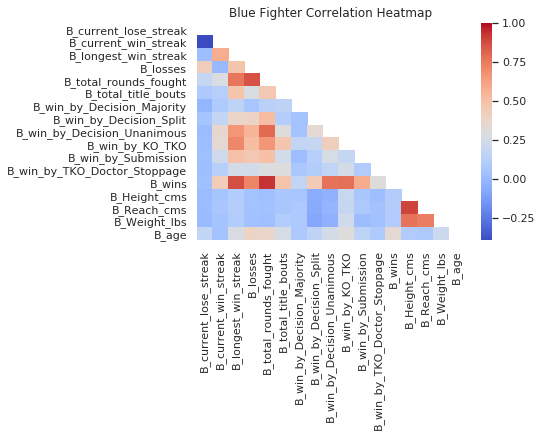

In [18]:
df_blue = UFC_FINAL.iloc[:,1:18]

corr = df_blue.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False,cmap="coolwarm").set_title("Blue Fighter Correlation Heatmap")
#df_blue.to_csv("df_blue.csv",index=False)

## Choropleth Map:
The produced choropleth map displays the density of events held worldwide with the United States, Brazil and Canada ranking 1 to 3.

In [19]:
#Choropleth Map:

# extract country from location
ufc_raw = pd.read_csv("https://raw.githubusercontent.com/Pitch2342/Rand/master/UFC_Dataset/data.csv")
ufc_raw["country"] = ufc_raw["location"].apply(lambda loc: loc.split(',')[-1][1:])

# convert country to alpha3 code
country_codes = []
for country in ufc_raw["country"]: 
    if (country == 'Russia' or country ==  'russia'):
        country = "Russian Federation"
    if (country == 'South Korea'):
        country = "KR"        
    country_codes.append(pycountry.countries.lookup(country).alpha_3)

# value counts dataframe
ufc_worldwide = pd.DataFrame(np.array(country_codes))
ufc_worldwide = ufc_worldwide.iloc[:,0].value_counts().reset_index().rename(columns={"index":"country_code",0:"matches"})
print("Generate countries' alpha3 codes and their value counts ")
ufc_worldwide.head()



Generate countries' alpha3 codes and their value counts 


,country_code,matches
0,USA,3392
1,BRA,405
2,CAN,342
3,GBR,255
4,AUS,162


In [20]:
fig1 = go.Figure(
  data = go.Choropleth(
    locations = ufc_worldwide['country_code'], #alpha3 codes
    z = ufc_worldwide['matches'],
    text = "Matches",
    colorscale = 'Blues',
    autocolorscale = False,
    marker_line_color = 'lightgrey',
    marker_line_width = 0.5,
    colorbar_title = 'No. of Matches'
  )
)

fig1.update_layout(
  title = {
    'text': "1993 - 2019 UFC WORLDWIDE",
    'x': 0.5,
    'y': 0.87,
  },
  geo = dict(
    showframe = False,
    showcoastlines = True,
    projection_type = 'equirectangular',
    showland = False,
    showlakes = True,

  )

)

fig1.show()

# Modeling
## Deep Neural Network (DNN) with Early Stopping Callback



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

# encode blue and red as 1 and 0
UFC_FINAL["Winner"] = UFC_FINAL["Winner"].replace("Blue", 1)
UFC_FINAL["Winner"] = UFC_FINAL["Winner"].replace("Red", 0)

# train/test split
X = UFC_FINAL.drop("Winner", axis=1).values
y = UFC_FINAL["Winner"].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=101)

# scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape} | y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")

# model
model = Sequential()

# input layer
model.add(Dense(units=42, activation='relu'))
model.add(Dropout(0.5)) # deactivates 50% of nodes

# h1
model.add(Dense(units=42, activation='relu'))
model.add(Dropout(0.5))

# h2
model.add(Dense(units=42, activation='relu'))
model.add(Dropout(0.5))

# h3
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping # prevent diverge of loss & val_loss
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)

X_train shape: (3476, 42) | X_test shape: (1159, 42) | y_train shape: (3476,) | y_test shape: (1159,)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3476 samples, validate on 1159 samples
Epoch 1/100
3476/3476 [==============================] - 0s 123us/sample - loss: 0.6574 - acc: 0.6381 - val_loss: 0.6488 - val_acc: 0.6644
Epoch 2/100
3476/3476 [==============================] - 0s 73us/sample - loss: 0.6370 - acc: 0.6787 - val_loss: 0.6425 - val_acc: 0.6644
Epoch 3/100
3476/3476 [==============================] - 0s 77us/sample - loss: 0.6369 - acc: 0.6798 - val_loss: 0.6372 - val_acc: 0.6644
Epoch 4/100
3476/3476 [==============================] - 0s 74us/sample - loss: 0.6309 - acc: 0.6821 - val_loss: 0.6356 - val_acc: 0.6644
Epoch 5/100
3476/3476 [==============================] - 0s 69us/sample - loss: 0.6305 - acc: 0.6824 - val_loss: 0.6340 - val_acc: 0.6644
Epoch 6/100
3476/3476 [==============================] - 0s 71us/sample - loss: 0.6269

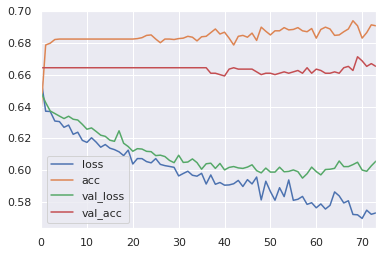

In [22]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=100,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()